In [1]:
%matplotlib inline
from numpy import *
import sklearn.datasets
from matplotlib.pyplot import *
import copy
import scipy
from scipy.sparse.linalg import *


**PDE**:
implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix *A* and the the right hand side *b*

In [2]:
def finDif(omega,f,n,bc):
    points=linspace(omega[0],omega[1],n) #punti di discretizzazione
    b=zeros(n) #termine noto
    A = zeros((n,n))
    for i in range(1,n-1):
        b[i]=f(points[i])
    b[0]=bc[0]
    b[n-1]=bc[1]
    h=(omega[1]-omega[0])/n #passo di discretizzazione
    for i in range(2,n-2):
        A[i, i-1] = A[i, i+1] = -16/(12*h**2)
        A[i, i-2] = A[i, i+2] = 1/(12*h**2)
        A[i,i] = 30/(12*h**2)
  
    A[1,0]=A[1,2]=A[n-2,n-3]=A[n-2,n-1]=-1/h**2
    A[1,1]=A[n-2,n-2]=2/h**2
    A[0,0] = A[-1,-1]=1
    return A, b

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix 

In [5]:
def LU(A):
    U=copy.deepcopy(A)
    n=len(A)
    L=eye(n) #L ha elementi diagonali pari a 1
    for j in range(n-1):
        for i in range(j+1,n):
            L[i,j]=U[i,j]/U[j,j]
            U[i,j:]-=L[i,j]*U[j,j:]
    return L, U

In [6]:
def cholesky(A):
    n=len(A)
    H=zeros([n,n])
    for j in range(n):
        H[j,j]=(A[j,j]-sum(fromiter((H[j,k]**2 for k in range(j)),float)))**0.5
        for i in range(j+1,n):
            H[i,j]=(A[i,j]-sum(fromiter((H[i,k]*H[j,k] for k in range(j)),float)))/H[j,j]
    return H, transpose(H)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.


In [7]:
def L_solve(L,rhs):
    n=len(L)
    x=zeros(n)
    for i in range(n):
        x[i] = rhs[i]
        for j in range(i):
            x[i] -= x[j]*L[i,j]
        x[i] = x[i]/L[i,i]
    return x

In [8]:
def U_solve(U,rhs):
    n=len(U)
    x=zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = rhs[i]
        for j in range(n-1, i, -1):
            x[i] -= x[j]*U[i,j]
        x[i] = x[i]/U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution

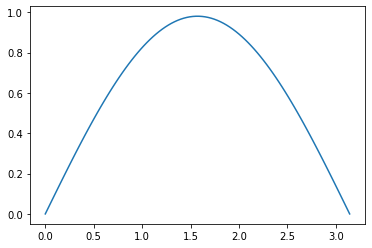

In [9]:
def LU_solve(A,b):
        L,U=LU(A)
        y=U_solve(U,L_solve(L,b))
        return y

xspace=linspace(0,pi,n)
plot(xspace,LU_solve(A,b))

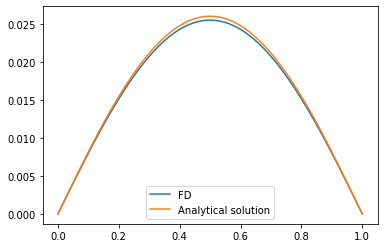

In [12]:
omega = [0,1]
f = lambda x : x*(1-x) # forcing term
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)
L,U=LU(A)
x=linspace(0,1,n)
y_an=x**4/12-x**3/6+x/12 #analytical solution
y=U_solve(U,L_solve(L,b))
plot(x,y, label = 'FD' )
plot(x,y_an, label = 'Analytical solution')
legend()


Exploit the derived LU factorizations to compute the condition number of the system's matrix using the original problem formulation.

In [14]:
def direct_power_method(A,nmax,tol):
    x0=random.rand(len(A)) #vettore iniziale arbitrario
    y = x0/linalg.norm(x0,2) #vettore iniziale normalizzato
    it = 0
    err = tol + 0.1
    while it < nmax and err > tol:
        x = dot(A,y)
        ev = dot(y.T,x) #eigenvalue
        err = linalg.norm(x-ev*y,2)
        y = x/linalg.norm(x,2)
        it += 1
    return ev,y

def inverse_power_method(A,nmax,tol):
    n=len(A)
    L,U=LU(A)
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i])) #trovo matrice inversa
    ev,y=direct_power_method(B,nmax,tol)
    return 1/ev,y


def condNumb(A):
    ev1,x1=direct_power_method(A,500,1e-05)
    ev2,x2=inverse_power_method(A,500,1e-05)
    return ev1/ev2

print(condNumb(A))

53312.81051823134


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:



In [15]:
def conjugate_gradient(A, b, P, nmax, eps=1e-10):

    x_k = zeros_like(b)
    r_k=b-dot(A,x_k)
    z_k=LU_solve(P,r_k)
    p_k=z_k #allo step zero la direzione è quella del residuo
    tol=eps+1
    i=0
    while (i<nmax and tol>eps):
        temp=dot(A,p_k)
        alpha=dot(p_k.T,r_k)/dot(p_k.T,temp)
        x=x_k+alpha*p_k
        r=r_k-alpha*temp
        z=LU_solve(P,r)
        beta=dot(temp.T,z)/dot(temp.T,p_k) 
        p=z-beta*p_k #nuova direzione di rcerca del punto di minimo
        tol=linalg.norm(r,2)
        x_k=x
        r_k=r
        p_k=p
        z_k=z
    
    return x
        

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.00000000e+04, -1.00000000e+04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.83333333e+04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.17265896e+04, -1.24487673e+04,  8.33333333e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  9.38415372e+03, -9.28936429e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

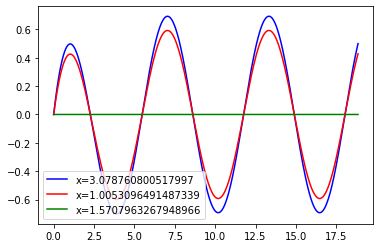

In [19]:
def PDEsol(f,alpha,nt,nx,a,b,T,g,q,p):
    x=linspace(a,b,nx) #discretizzo entrambe le variabili x e t
    t=linspace(0,T,nt)

    ht=T/nt
    hx=(b-a)/nx
    
    A=zeros((nx,nx),dtype=float)
    for i in range(2,nx-2):
        A[i, i-1] = A[i, i+1] = -16/12
        A[i, i-2] = A[i, i+2] = 1/12
        A[i,i] = 30/(12*h**2)
  
    A[1,0]=A[1,2]=A[n-2,n-3]=A[n-2,n-1]=-1
    A[1,1]=A[n-2,n-2]=2
    A[0,0] = A[-1,-1]=1
    
    A=ht*A/hx**2

    fx=f(x)
    alphat=alpha(t)
    
    U=zeros((nt,nx),dtype=float) #pongo condizioni iniziali: u(0,x)=0, u(t,x_0)=0, u(t,x_n)=0
    
    for i in range(1,nt):
        U[i,:]=dot(A,U[i-1,:])+ht*fx*alphat[i]
      
    return U

a=0
b=pi
T=6*pi
f = lambda x : sin(x)
alpha= lambda x: cos(x)
nx=50
nt=100000
bc=[0,0]
sol=PDEsol(f,alpha,nt,nx,a,b,T)

#computation of approximate x
pai=argmin(abs(linspace(a,b,nx)-pi))*(b-a)/nx
pai2=argmin(abs(linspace(a,b,nx)-pi/2))*(b-a)/nx
one=argmin(abs(linspace(a,b,nx)-1))*(b-a)/nx



plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-pi/2))], '-b', label='x={}'.format(pai))
plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-1))], '-r',label='x={}'.format(one))
plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-pi))], '-g',label='x={}'.format(pai2))
matplotlib.pyplot.legend()

Given the original system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix . Exploit the computed LU factorization

In [ ]:
def eigendecomposition(A,nmax,tol=1e-08):
    n=len(A)
    d=zeros(n) #autovalori
    V=zeros([n,n]) #autovettori
    for i in range(n):
        d[i],V[:,i]=direct_power_method(A,nmax,tol)
        A=A-d[i]*outer(V[:,i],V[:,i])
    return d,V

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
def inverse(A):
    n=shape(A)[0]
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    return B

Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

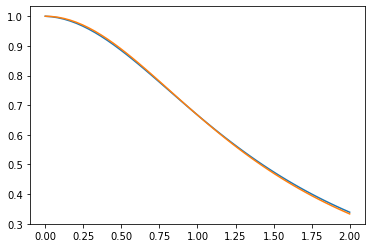

In [20]:
def newton(f,f1,x0,epsilon=1e-10,max_iter=500):
    x = x0
    for n in range(0,max_iter):
        if abs(f(x)) < epsilon:
            return x
        if f1(x) == 0:
            return None
        x = x - f(x)/f1(x)
    return x


def backward_euler(y0,f,f1,omega,n):
    tspace=linspace(omega[0],omega[1],n)
    h=(omega[1]-omega[0])/n
    F=lambda t,z,x: z-h*f(t,z)-x # F(u_n+1) = u_n+1 - u_n - h*f_n+1
    F1=lambda t,z,x: 1-h*f1(t,z) #F'(u_n+1)
    y=zeros(n)
    y[0]=y0
    for i in range(1,n):
        Ft=lambda z: F(tspace[i],z,y[i-1])
        Ft1=lambda z: F1(tspace[i],z,y[i-1])
        y[i]=newton(Ft,Ft1,y[i-1])
    return y

n=50
f=lambda t,y: -t*(y**2)
f1=lambda t,y: -t*2*y
y=backward_euler(1,f,f1,array([0,2]),n)
plot(linspace(0,2,n),y)
plot(linspace(0,2,n),2/(linspace(0,2,n)**2+2))